# Centers for Medicare & Medicaid Services - 2016 Physician Compare

Loading libraries

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

Importing physician NPI data and their location

In [2]:
# Convert to boolean function
def convert_bool(col):
    if str(col).title() ==  'Y':
        return True
    elif str(col).title() == 'N':
        return False
    else:
        return col

# Importing and changing categories
npi = pd.read_csv('physician_compare/Physician_Compare_National_Downloadable_File.csv',
                  usecols=[0, 1, *range(7, 12), 16, *range(18, 21), *range(23, 26), *range(37, 41)],
                  dtype = {'NPI' : 'category',
                           'PAC ID' : 'category',
                           'Gender' : 'category',
                           'Credential' : 'category',
                           'Medical school name' : 'category',
                           'Graduation year' : 'object',
                           'Primary Specialty' : 'category',
                           'All secondary specialties' : 'object',
                           'Organization legal name' : 'object',
                           'Group Practice PAC ID' : 'object',
                           'Number of Group Practice members' : 'object',
                           'Line 1 Street Address' : 'object',
                           'Line 2 Street Address' : 'object',
                           'City' : 'category',
                           'State' : 'category',
                           'Zip Code' : 'category'},
                           converters={'Professional accepts Medicare Assignment' : lambda x:convert_bool(x),
                                       'Reported Quality Measures' : lambda x:convert_bool(x),
                                       'Used electronic health records' : lambda x:convert_bool(x),
                                       'Committed to heart health through the Million Hearts® initiative.' : lambda x:convert_bool(x)})

# Changing column names
npi.columns = ['npi', 'pac_id', 'gender', 'credential', 'med_school', 'grad_year', 'prim_specialty', 
               'all_sec_specialties', 'group_prac_pac_id', 'group_mem_num', 'street', 'city', 'state',
               'zip', 'accepts_medicare_assign', 'reported_quality', 'ehr', 'heart_init']


# Converting to boolean
npi['accepts_medicare_assign'] = npi['accepts_medicare_assign'].astype('bool')
npi['reported_quality'] = npi['reported_quality'].astype('bool')
npi['ehr'] = npi['ehr'].astype('bool')
npi['heart_init'] = npi['heart_init'].astype('bool')

# Changing object values to numeric
npi.grad_year = pd.to_numeric(npi.grad_year, errors='coerce')
npi.group_mem_num = pd.to_numeric(npi.group_mem_num, errors='coerce')

# Change postal codes to 5 digit zip codes
npi.zip = npi.zip.str[:5]

# Display data frame
# npi

# Determining what datatypes are available 
# npi.dtypes

# Find what unique categories are avilable. Converted to string for easier reading.
# npi['...'].astype('str').unique()

Importing US Census Bureau American 2016 Community Survey 5-year estimates for poverty and median household income

In [3]:
# Importing census data poverty percentages
census_poverty = pd.read_csv("census_acs/ACS_16_5YR_S1701_with_ann.csv", skiprows=[0], usecols=[1, 8],
                    dtype={'Id2' : 'object'})
census_median_household = pd.read_csv("census_acs/ACS_16_5YR_S1903_with_ann.csv", skiprows=[0], usecols=[1, 5],
                    dtype={'Id2' : 'object'})
census_poverty_state = pd.read_csv("census_acs/state/ACS_16_5YR_S1701_with_ann.csv", skiprows=[0], usecols=[2, 7],
                    dtype={'Id2' : 'object'})
census_median_household_state = pd.read_csv("census_acs/state/ACS_16_5YR_B19013_with_ann.csv", skiprows=[0], usecols=[2, 3],
                    dtype={'Id2' : 'object'})

# Renaming column names
census_poverty.columns = ['zip', 'percent_poverty_zip']
census_poverty_state.columns = ['state', 'percent_poverty_state']

census_median_household.columns = ['zip', 'median_household_zip']
census_median_household_state.columns = ['state', 'median_household_state']

# Changing poverty percentage from object to float
census_poverty.percent_poverty_zip = pd.to_numeric(census_poverty.percent_poverty_zip, errors='coerce')
census_median_household.median_household_zip = pd.to_numeric(census_median_household.median_household_zip, errors='coerce')
census_poverty_state.percent_poverty_state = pd.to_numeric(census_poverty_state.percent_poverty_state, errors='coerce')
census_median_household_state.median_household_state = pd.to_numeric(census_median_household_state.median_household_state, errors='coerce')

# Show dataframe
# census_poverty
# census_median_household

State name to two leter state converter:

In [4]:
# Creating dictionary
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'Puerto Rico' : 'Puerto Rico',
    'District of Columbia' : 'DC'
}

# Converting full state name to acronym
census_poverty_state.state = [us_state_abbrev[state] for state in census_poverty_state.state]
census_median_household_state.state = [us_state_abbrev[state] for state in census_median_household_state.state]

# Checking
# census_poverty_state
# census_median_household_state

Performing a left join of npi and census data

In [5]:
npi = pd.merge(npi, census_poverty, how='left', on='zip')
npi = pd.merge(npi, census_median_household, how='left', on='zip')
npi = pd.merge(npi, census_poverty_state, how='left', on='state')
npi = pd.merge(npi, census_median_household_state, how='left', on='state')

Importing physician performance

In [6]:
# Importing and changing categories
pc_phys_perf = pd.read_csv("physician_compare/Physician_Compare_2016_Individual_EP_Public_Reporting.csv",
                  dtype = {"NPI" : "object",
                           "PAC ID" : "category",
                           "Last Name" : "object",
                           "First Name" : "object",
                           "Measure Identifier" : "category",
                           "Measure Title" : "category",
                           "Measure Performance Rate": "float64",
                           "Reporting Mechanism": "category",
                           "Footnote": "object"},
                           converters={"Inverse Measure": lambda x:convert_bool(x),
                                      "Reported on PC Live Site": lambda x:convert_bool(x)})

# Converting to boolean
pc_phys_perf["Inverse Measure"] = pc_phys_perf["Inverse Measure"].astype("bool")
pc_phys_perf["Reported on PC Live Site"] = pc_phys_perf["Reported on PC Live Site"].astype("bool")

# Display data frame
# pc_phys_perf

##Determining what datatypes are available 
#pc_phys_perf.dtypes

# Find what unique categories are avilable. Converted to string for easier reading.
# pc_phys_perf['Measure Title'].astype('str').unique()

Joining npi and US Census ACS data to physician performance data.

In [7]:
pc_phys_perf = pd.merge(pc_phys_perf, npi, how='left', left_on='NPI', right_on='npi')

In [8]:
pc_phys_perf

,NPI,PAC ID,Last Name,First Name,Measure Identifier,Measure Title,Inverse Measure,Measure Performance Rate,Denominator Count,Collection Type,...,state,zip,accepts_medicare_assign,reported_quality,ehr,heart_init,percent_poverty_zip,median_household_zip,percent_poverty_state,median_household_state
0,1508823618,0042100117,GRIFFIN,DAVID,PQRS_EP_110_1,Preventive Care and Screening: Influenza Immun...,False,20.0,71,CLM,...,SC,29607,True,True,True,False,2.2,50777.0,17.2,46898.0
1,1508823618,0042100117,GRIFFIN,DAVID,PQRS_EP_110_1,Preventive Care and Screening: Influenza Immun...,False,20.0,71,CLM,...,SC,29607,True,True,True,False,2.2,50777.0,17.2,46898.0
2,1508823618,0042100117,GRIFFIN,DAVID,PQRS_EP_110_1,Preventive Care and Screening: Influenza Immun...,False,20.0,71,CLM,...,SC,29621,True,True,True,False,2.3,52254.0,17.2,46898.0
3,1508823618,0042100117,GRIFFIN,DAVID,PQRS_EP_111_1,Pneumonia Vaccination Status for Older Adults,False,41.0,90,CLM,...,SC,29607,True,True,True,False,2.2,50777.0,17.2,46898.0
4,1508823618,0042100117,GRIFFIN,DAVID,PQRS_EP_111_1,Pneumonia Vaccination Status for Older Adults,False,41.0,90,CLM,...,SC,29607,True,True,True,False,2.2,50777.0,17.2,46898.0
5,1508823618,0042100117,GRIFFIN,DAVID,PQRS_EP_111_1,Pneumonia Vaccination Status for Older Adults,False,41.0,90,CLM,...,SC,29621,True,True,True,False,2.3,52254.0,17.2,46898.0
6,1508823618,0042100117,GRIFFIN,DAVID,PQRS_EP_113_1,Colorectal Cancer Screening,False,29.0,70,CLM,...,SC,29607,True,True,True,False,2.2,50777.0,17.2,46898.0
7,1508823618,0042100117,GRIFFIN,DAVID,PQRS_EP_113_1,Colorectal Cancer Screening,False,29.0,70,CLM,...,SC,29607,True,True,True,False,2.2,50777.0,17.2,46898.0
8,1508823618,0042100117,GRIFFIN,DAVID,PQRS_EP_113_1,Colorectal Cancer Screening,False,29.0,70,CLM,...,SC,29621,True,True,True,False,2.3,52254.0,17.2,46898.0
9,1508823618,0042100117,GRIFFIN,DAVID,PQRS_EP_130_1,Documentation of Current Medications in the Me...,False,91.0,255,CLM,...,SC,29607,True,True,True,False,2.2,50777.0,17.2,46898.0


### Subsetting Smoking Data

In [198]:
smoking_rows = pc_phys_perf[pc_phys_perf['Measure Title'] == 'Preventive Care and Screening: Tobacco Use: Screening and Cessation Intervention'].dropna(subset=['Measure Performance Rate', 'median_household_zip'])
smoking_rows.drop_duplicates(subset=['NPI', 'Measure Performance Rate', 'zip'], keep='first', inplace=True)

Creating training and test data sets for lienar regression

In [199]:
X_train, X_test, y_train, y_test = train_test_split(smoking_rows['Measure Performance Rate'].values.reshape(-1, 1),
                                                    smoking_rows['median_household_zip'].values.reshape(-1, 1),
                                                    test_size = .25, random_state=25)

Deploying and evaluating model

Coefficients: 
 [[28.11879139]]
Mean squared error: 518043967.31
Variance score: 0.00


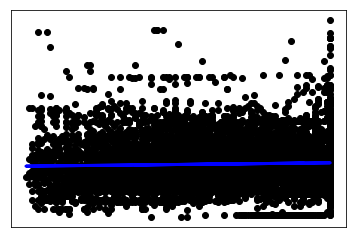

In [200]:
LinReg = LinearRegression()
LinReg.fit(X_train, y_train)
y_pred = LinReg.predict(X_test)

# The coefficients
print('Coefficients: \n', LinReg.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [189]:
smoking_rows['percent_poverty_zip'].min()

0.2